In [ ]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
from keras.layers import Dense, Input, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## Load Data

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
#print(train_data.head())


y = train_data['Class']

## Train Data Size
n = len(y)

In [ ]:
#Find size estimate of images

xsizes = []
ysizes = []

for file in train_data['ID']:
    path = 'images/'+file
    img_pil = image.load_img(path,color_mode="rgba")
    xsizes.append(img_pil.size[0])
    ysizes.append(img_pil.size[1])

sizes = (np.array(xsizes).mean(),np.array(ysizes).mean())

print(sizes)

(1055.875, 911.875)


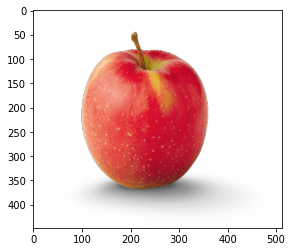

In [40]:
path = 'images/'+train_data['ID'][0]
img_pil = image.load_img(path, grayscale=False, color_mode="rgba", target_size=(448,512), interpolation="nearest")
plt.imshow(img_pil)

In [45]:
## Define Functions to Pre-process images

px = 448; py = 512   # Fix the target image size

def process_train_data(file):
    path = 'images/'+file
    img_pil = image.load_img(path, grayscale=False, color_mode="rgba", target_size=(px,py), interpolation="nearest")
    arr = image.img_to_array(img_pil, data_format='channels_last')
    arr = arr/255
    return arr


def process_test_data(file):
    path = 'images/'+file
    img_pil = image.load_img(path, grayscale=False, color_mode="rgba", target_size=(px,py), interpolation="nearest")
    arr = image.img_to_array(img_pil, data_format='channels_last')
    arr = arr/255
    return arr


In [46]:
## Create Keras Convolutional Net Model


X_input = Input(shape=(px,py,4))
l2_reg = l2(0.0005)

X = Conv2D(16, (7, 7), strides = (1, 1), padding = 'same', kernel_regularizer=l2_reg, name = 'conv0')(X_input)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(32, (5, 5), strides = (1, 1), padding = 'same', kernel_regularizer=l2_reg, name = 'conv1')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool0')(X)
X = Conv2D(32, (5, 5), strides = (1, 1), padding = 'same', kernel_regularizer=l2_reg, name = 'conv2')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool1')(X)
X = Conv2D(32, (5, 5), strides = (1, 1), padding = 'same', kernel_regularizer=l2_reg, name = 'conv3')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool2')(X)
X = Conv2D(32, (5, 5), strides = (1, 1), padding = 'same', kernel_regularizer=l2_reg, name = 'conv4')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool3')(X)


X = Flatten()(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)

X = Dense(units=50, activation='relu', kernel_regularizer=l2_reg)(X)
X = BatchNormalization()(X)
#X = Dropout(0.2)(X)

Y = Dense(units=1, activation='sigmoid', kernel_regularizer=l2_reg)(X)

convnetmodel = Model(inputs=X_input, outputs=Y)

In [47]:
## Define Optimizer and Compile Model

opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
convnetmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
## Train Model

X_train = train_data['ID'].map(process_train_data)
bs = len(X_train)
X_train_arr = np.zeros((bs,px,py,4))
for k in range(bs):
    X_train_arr[k] = X_train.iloc[k]

# Final Train
convnetmodel.fit(X_train_arr, y, epochs=50)

# Option to train while evaluating
#convnetmodel.fit(X_train_arr, y, validation_split=0.2, epochs=50)

In [35]:
## Generate Solution

solution = test_data[['ID']]


X_test = test_data['ID'].map(process_test_data)
bs = len(X_test)
X_test_arr = np.zeros((bs,p,p,4))
for k in range(bs):
    X_test_arr[k] = X_test.iloc[k]

y_pred_probs = convnetmodel.predict(X_test_arr)[:,0]
y_pred = (y_pred_probs>=0.5).astype(int)

solution['Class'] = y_pred
solution.to_csv('solution.csv',index=False)